In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
!pip install h2o
import h2o
h2o.init()
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

%matplotlib inline

import xgboost
import lightgbm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpei65qwk6
  JVM stdout: /tmp/tmpei65qwk6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpei65qwk6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,2 months and 19 days
H2O_cluster_name:,H2O_from_python_unknownUser_4jvyr9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
data = df = pd.read_csv('/kaggle/input/stroke-data-visual/stroke_data.csv')

In [6]:
df.head()

,Gender,Age,AF,Localisation,AMI_Unst.ang,GFR,Surv,Q_non_Q,DM
0,male,56,No_AF,Left_car,AMI,14,death,non_Q,Diabetes
1,male,59,No_AF,Left_car,Unst_ang,98,alive,NaN,No_Diabetes
2,female,86,AF,Left_car,AMI,57,death,non_Q,Diabetes
3,female,83,AF,Left_car,Unst_ang,69,alive,NaN,No_Diabetes
4,female,78,AF,Left_car,AMI,54,death,non_Q,No_Diabetes


Это как выглядят данные

**BASIC STATISTICS**

In [8]:
columns = ['Age', 'GFR'] # это все численные данные
cat_columns = ['Gender','AF', 'Localisation', 'AMI_Unst.ang', 'Q_non_Q', 'DM'] # это все категориальные данные

In [9]:
from scipy import stats
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr

data_death = df[df['Surv'] == 'death']
data_alive = df[df['Surv'] == 'alive']
for i in columns:
  lst1 = data_death[i]
  lst2 = data_alive[i]
  shapiro_test = stats.shapiro(lst1) # тест шапиро-уилка
  shapiro_test2 = stats.shapiro(lst2) # тест шапиро-уилка
  if shapiro_test[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test[1]))
  if shapiro_test2[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test2[1]))
  else:
    pass

Данные GFR распределены ненормально,           p-value - 0.02445145882666111
Данные GFR распределены ненормально,           p-value - 0.019940052181482315


При помощи теста Шапиро-Уилка определяем распределение
Данный код возвращает "Данные GFR распределены ненормально,  " если р-значение менее 0,05

In [11]:
def Basic_statistics(lst_1, lst_2):
    """ 
    Функция "Базовые статистики"

    На вход получает 2 списка данных для сравнения.
    На выходе получаем p-values, при сравнении признаков. 
    
    """
    res_mw = mannwhitneyu(lst_1, lst_2, 
                       use_continuity=True, 
                       alternative=None) # u -тест манна-уитни
    res_kw = kruskal(lst_1, lst_2)## краскела уолиса
    anova = stats.f_oneway(lst_1, lst_2) #тест анова
    return res_mw[1], res_kw[1],  anova[1]
for col in columns:
  lst1 = data_death[col]
  lst2 = data_alive[col]
  mw =  Basic_statistics(lst1, lst2)[0]
  kw =  Basic_statistics(lst1, lst2)[1]
  an =  Basic_statistics(lst1, lst2)[2]
  if mw < .05:
    print('Данные {0} статисически значимо различаются в подгруппах,\
           p-value - {1}, тест Манна-Уитни'.format(col,  mw))
  else:
    pass


Данные GFR статисически значимо различаются в подгруппах,           p-value - 6.0031674812052315e-06, тест Манна-Уитни


Так как данные СКФ в подгруппах распределены ненормально, используется U-тест Манна-Уиттни 
Функция возвращает текст если уровень значимости менее 0,05, в нашем случае менее 0,0000006 (e-06) => это значит - 6 степень

In [12]:
from scipy import stats
oddsratio, pvalue = stats.fisher_exact([[52, 11], [61, 30]]) # точный тест фишера
print(oddsratio, pvalue) # группы сравниваю по диабету

2.324888226527571 0.04121117008863266


p < 0,05

## Непосредственно обучение модели машинного обучения GBM (градиентный бустинг)

In [13]:
data=h2o.H2OFrame(df)
predictors = data.col_names # определяем признаки, которые будут использоваться в качестве предсказателей
predictors.remove('Surv') # убираем из этого списка целевую - "Surv"(выживаемость)
data['Surv'] = data['Surv'].asfactor() # определяем "Surv" как фактор, который нужно предсказать
train, test = data.split_frame(seed = 12345, ratios = [.8]) # здесь вся таблица случайным образом разделяется на тренировочную часть
# и тестовую 80 на 20 %
target = 'Surv'

hyperparams_tune = { # на это можно не обращать внимание, это подбор гиперпараметров для модели
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'col_sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

search_criteria_tune = {# на это можно не обращать внимание, это подбор гиперпараметров для модели
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  ## limit the runtime to 5 minutes
    'max_models' : 15,  ## build no more than 15 models
    'stopping_rounds' : 5,
    'stopping_metric' : "AUC",
    'stopping_tolerance': 1e-3}
gbm_final_grid = H2OGradientBoostingEstimator(nfolds = 3, # непосредственно инициализация модели
    ## More trees is better if the learning rate is small enough
    ## we use "more than enough" trees with early stopping
    ntrees = 10000,
    ## we use learn rate with annealing for a fast scan
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    ## Score every 10 trees to make early stopping reproducible
    score_tree_interval = 10,
    ## Set seed for reproducibility
    seed = 12345)
final_grid = H2OGridSearch(
    gbm_final_grid,
    hyper_params = hyperparams_tune,
    grid_id = 'gbm_final_grid',
    search_criteria = search_criteria_tune)
final_grid.train( # здесь мы начинаем тренировать модель X => предсказатели,Y => показатель, который нужно научиться предсказывать
    x = predictors,
    y = target,
    max_runtime_secs = 180, # can override setting in search_criteria_tune
    training_frame = train)
    
    
sorted_gbm_grid = final_grid.get_grid(sort_by = "auc", decreasing = True)  # сортируем все полученные модели
best_gbm = sorted_gbm_grid.models[0] # выбираем наилучшую модель


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [14]:
# теперь мы даём нашей модели тестовые данные, которые ранее модель не видела и мы хотим посмотреть насколько она хорошо
# может предсказывать целевое значение
best_gbm.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.07041221211830823
RMSE: 0.26535299530683315
LogLoss: 0.2648106336689203
Mean Per-Class Error: 0.045454545454545414
AUC: 0.9909090909090909
AUCPR: 0.9920898748191246
Gini: 0.9818181818181817

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5176381485281193: 


,,alive,death,Error,Rate
0,alive,9.0,1.0,0.1,(1.0/10.0)
1,death,0.0,11.0,0.0,(0.0/11.0)
2,Total,9.0,12.0,0.0476,(1.0/21.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.517638,0.956522,11.0
1,max f2,0.517638,0.982143,11.0
2,max f0point5,0.803445,0.980392,9.0
3,max accuracy,0.803445,0.952381,9.0
4,max precision,0.969969,1.000000,0.0
5,max recall,0.517638,1.000000,11.0
6,max specificity,0.969969,1.000000,0.0
7,max absolute_mcc,0.803445,0.909091,9.0
8,max min_per_class_accuracy,0.803445,0.909091,9.0
9,max mean_per_class_accuracy,0.803445,0.954545,9.0



Gains/Lift Table: Avg response rate: 52.38 %, avg score: 56.85 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.047619,0.962971,1.909091,1.909091,1.000000,0.969969,1.000000,0.969969,0.090909,0.090909,90.909091,90.909091,0.090909
1,2,0.047619,0.955974,0.000000,1.909091,0.000000,0.000000,1.000000,0.969969,0.000000,0.090909,-100.000000,90.909091,0.090909
2,3,0.047619,0.948976,0.000000,1.909091,0.000000,0.000000,1.000000,0.969969,0.000000,0.090909,-100.000000,90.909091,0.090909
3,4,0.047619,0.941979,0.000000,1.909091,0.000000,0.000000,1.000000,0.969969,0.000000,0.090909,-100.000000,90.909091,0.090909
4,5,0.095238,0.934981,1.909091,1.909091,1.000000,0.934981,1.000000,0.952475,0.090909,0.181818,90.909091,90.909091,0.181818
5,6,0.142857,0.926429,1.909091,1.909091,1.000000,0.926429,1.000000,0.943793,0.090909,0.272727,90.909091,90.909091,0.272727
6,7,0.190476,0.897443,1.909091,1.909091,1.000000,0.897443,1.000000,0.932206,0.090909,0.363636,90.909091,90.909091,0.363636
7,8,0.238095,0.870200,1.909091,1.909091,1.000000,0.870200,1.000000,0.919804,0.090909,0.454545,90.909091,90.909091,0.454545
8,9,0.333333,0.851046,1.909091,1.909091,1.000000,0.858942,1.000000,0.902415,0.181818,0.636364,90.909091,90.909091,0.636364
9,10,0.428571,0.806539,1.909091,1.909091,1.000000,0.828255,1.000000,0.885935,0.181818,0.818182,90.909091,90.909091,0.818182


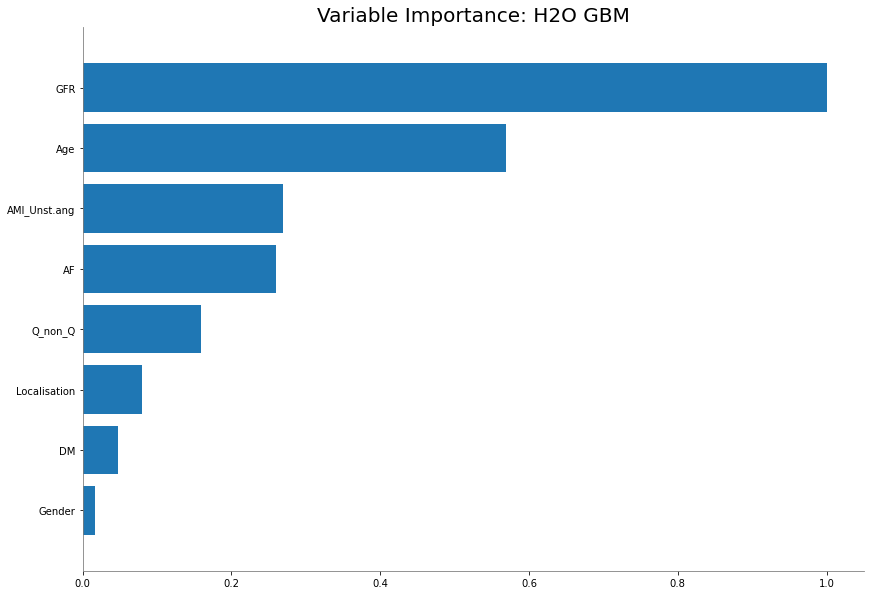

In [15]:
best_gbm.varimp_plot()

Обратите внимание, квадратик с цифрами - это матрица несоответствий, т.е. как машина смогла предсказать на тесте
Слева сверху - истинноотрицательное предсказание, справа сверху - ложноположительное предсказание; слева снизу - ложноотрицательное предсказание, и справа внизу - истинноположительное предсказание

Т.о. модель смогла предсказать исход на ранее не видимых ею данных с уровенем чувствительности - 100% и 91% специфичностью